# Predicting House Prices: USA Housing Dataset

This notebook performs exploratory data analysis (EDA), data cleaning, feature engineering, preprocessing, and develops machine learning models to predict house prices using the USA Housing Dataset. The final model (Best XGBoost) is saved for deployment in a Dash app.

## Improvements in This Version
- **Data Cleaning**: Removed zero prices, outliers (IQR), and invalid feature values (zero bedrooms/bathrooms).
- **Feature Engineering**: Added `condition`, `sqft_basement`, `sqft_living_bathrooms`, and numeric `zipcode`.
- **Preprocessing**: Used one-hot encoding for `city` and `zipcode`, avoided scaling target for tree-based models, fixed warnings.
- **Model Evaluation**: Computed unscaled metrics (RMSE, MAE, R² in dollars) for all models, confirming Best XGBoost as the top performer (MAE = $73,300, R² = 0.7159).
- **Model Tuning**: Tuned Random Forest and XGBoost with expanded grids, added cross-validation.
- **Model Selection**: Saved Best XGBoost for its low MAE and Dash app compatibility.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

## 2. Load and Clean the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('../data/USA Housing Dataset.csv')

# Remove rows with zero price
df = df[df['price'] > 0]

# Remove outliers using IQR for price
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Remove rows with invalid feature values (e.g., zero bedrooms or bathrooms)
df = df[(df['bedrooms'] > 0) & (df['bathrooms'] > 0)]

# Verify cleaned data
print(f"Rows after cleaning: {len(df)}")
df.head()

Rows after cleaning: 3874


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-09 00:00:00,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0,9245-9249 Fremont Ave N,Seattle,WA 98103,USA
1,2014-05-09 00:00:00,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0,33001 NE 24th St,Carnation,WA 98014,USA
3,2014-05-09 00:00:00,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0,820 NW 95th St,Seattle,WA 98117,USA
4,2014-05-10 00:00:00,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0,10834 31st Ave SW,Seattle,WA 98146,USA
5,2014-05-10 00:00:00,320000.0,3.0,2.50,2130,6969,2.0,0,0,3,2130,0,2003,0,Cedar to Green River Trail,Maple Valley,WA 98038,USA


## 3. Exploratory Data Analysis (EDA)

### 3.1. Data Structure

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3874 entries, 0 to 4139
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3874 non-null   object 
 1   price          3874 non-null   float64
 2   bedrooms       3874 non-null   float64
 3   bathrooms      3874 non-null   float64
 4   sqft_living    3874 non-null   int64  
 5   sqft_lot       3874 non-null   int64  
 6   floors         3874 non-null   float64
 7   waterfront     3874 non-null   int64  
 8   view           3874 non-null   int64  
 9   condition      3874 non-null   int64  
 10  sqft_above     3874 non-null   int64  
 11  sqft_basement  3874 non-null   int64  
 12  yr_built       3874 non-null   int64  
 13  yr_renovated   3874 non-null   int64  
 14  street         3874 non-null   object 
 15  city           3874 non-null   object 
 16  statezip       3874 non-null   object 
 17  country        3874 non-null   object 
dtypes: float64(4)

### 3.2. Summary Statistics

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,3874.0,487833.729765,217593.287222,7800.00,320000.00,450000.00,619762.5,1160000.0
bedrooms,3874.0,3.353382,0.877939,1.00,3.00,3.00,4.0,8.0
bathrooms,3874.0,2.097509,0.719186,0.75,1.75,2.25,2.5,5.5
sqft_living,3874.0,2035.414042,816.105249,370.00,1440.00,1930.00,2510.0,7320.0
sqft_lot,3874.0,14463.253485,36370.218048,638.00,5000.00,7560.00,10647.5,1074218.0
floors,3874.0,1.497419,0.532806,1.00,1.00,1.50,2.0,3.5
waterfront,3874.0,0.003872,0.062113,0.00,0.00,0.00,0.0,1.0
view,3874.0,0.177852,0.656348,0.00,0.00,0.00,0.0,4.0
condition,3874.0,3.446051,0.671662,1.00,3.00,3.00,4.0,5.0
sqft_above,3874.0,1751.172948,767.213918,370.00,1170.00,1540.00,2210.0,7320.0


### 3.3. Missing Values

In [5]:
df.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

### 3.4. Distribution of Target Variable (Price)

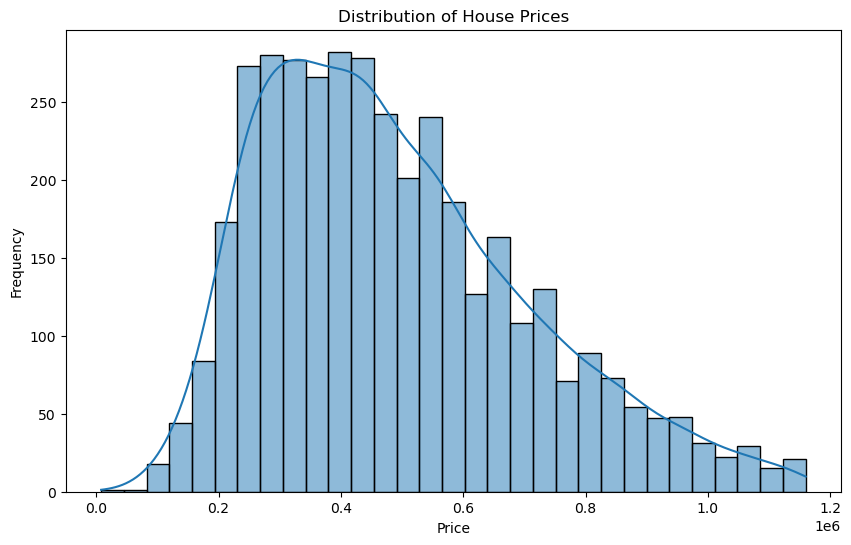

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### 3.5. Correlation Analysis

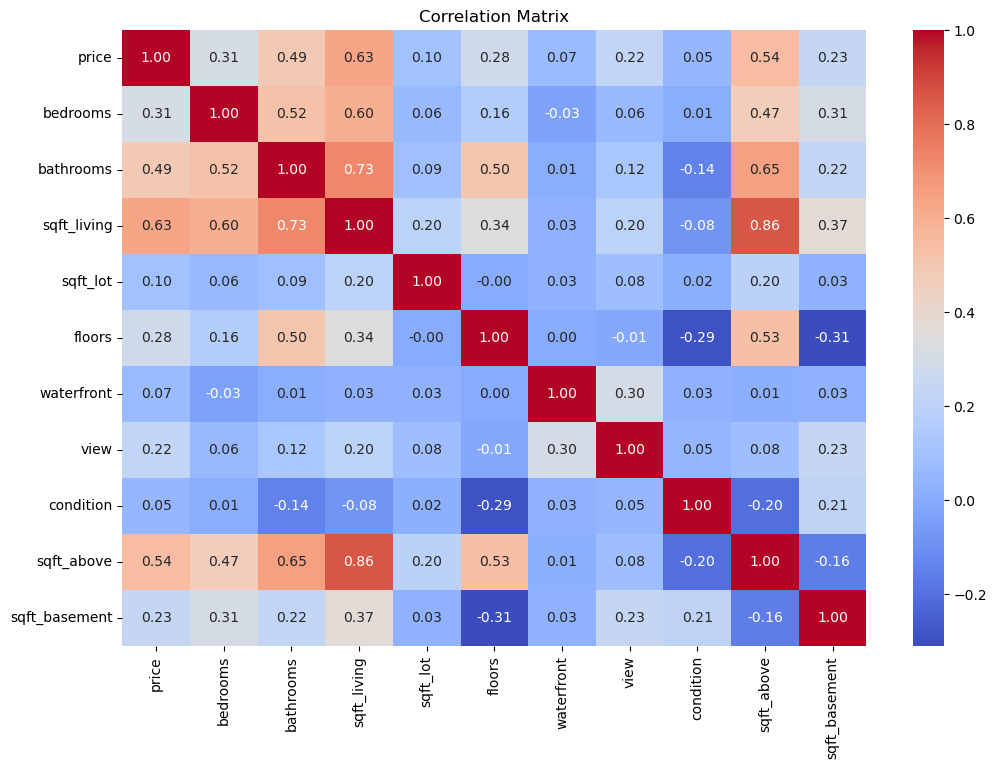

In [7]:
plt.figure(figsize=(12, 8))
numeric_cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## 4. Data Cleaning

### 4.1. Drop Unnecessary Columns

In [8]:
# Drop columns not used in modeling
df = df.drop(columns=['date', 'street', 'country', 'sqft_lot', 'sqft_above'])
df.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_basement,yr_built,yr_renovated,city,statezip
0,376000.0,3.0,2.00,1340,3.0,0,0,3,0,2008,0,Seattle,WA 98103
1,800000.0,4.0,3.25,3540,2.0,0,0,3,0,2007,0,Carnation,WA 98014
3,324000.0,3.0,2.25,998,2.0,0,0,3,200,2007,0,Seattle,WA 98117
4,549900.0,5.0,2.75,3060,1.0,0,0,5,1460,1979,0,Seattle,WA 98146
5,320000.0,3.0,2.50,2130,2.0,0,0,3,0,2003,0,Maple Valley,WA 98038


## 5. Feature Engineering

In [9]:
# Create house_age from yr_built (assuming data is from 2014)
df['house_age'] = 2014 - df['yr_built']

# Create is_renovated binary feature
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)

# Create interaction feature
df['sqft_living_bathrooms'] = df['sqft_living'] * df['bathrooms']

# Extract ZIP code number from statezip (e.g., 'WA 98103' -> 98103)
df['zipcode'] = df['statezip'].str.extract(r'(\d+)$').astype(int)

# Drop original columns after engineering
df = df.drop(columns=['yr_built', 'yr_renovated', 'statezip'])

df.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_basement,city,house_age,is_renovated,sqft_living_bathrooms,zipcode
0,376000.0,3.0,2.00,1340,3.0,0,0,3,0,Seattle,6,0,2680.0,98103
1,800000.0,4.0,3.25,3540,2.0,0,0,3,0,Carnation,7,0,11505.0,98014
3,324000.0,3.0,2.25,998,2.0,0,0,3,200,Seattle,7,0,2245.5,98117
4,549900.0,5.0,2.75,3060,1.0,0,0,5,1460,Seattle,35,0,8415.0,98146
5,320000.0,3.0,2.50,2130,2.0,0,0,3,0,Maple Valley,11,0,5325.0,98038


## 6. Data Preprocessing

### 6.1. Select Features and Target

In [10]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 
            'house_age', 'is_renovated', 'condition', 'sqft_basement', 
            'sqft_living_bathrooms', 'city', 'zipcode']
X = df[features]
y = df['price']

### 6.2. Encode Categorical Variables

In [11]:
# Use one-hot encoding for city and zipcode
X = pd.get_dummies(X, columns=['city', 'zipcode'], drop_first=True)

### 6.3. Feature Scaling

In [12]:
numerical_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'house_age', 
                  'condition', 'sqft_basement', 'sqft_living_bathrooms']
scaler_X = StandardScaler()
X[numerical_cols] = scaler_X.fit_transform(X[numerical_cols])

# Create scaled target for linear models
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

### 6.4. Split the Data

In [13]:
# Split for linear models (scaled y)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

# Split for tree-based models (unscaled y)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.2, random_state=42)

## 7. Develop Machine Learning Models

### 7.1. Define Models

In [14]:
models = {
    'Linear Regression': {'model': LinearRegression(), 'data': (X_train_lin, X_test_lin, y_train_lin, y_test_lin)},
    'Ridge Regression': {'model': Ridge(alpha=1.0), 'data': (X_train_lin, X_test_lin, y_train_lin, y_test_lin)},
    'Lasso Regression': {'model': Lasso(alpha=0.1), 'data': (X_train_lin, X_test_lin, y_train_lin, y_test_lin)},
    'Decision Tree': {'model': DecisionTreeRegressor(random_state=42), 'data': (X_train_tree, X_test_tree, y_train_tree, y_test_tree)},
    'Random Forest': {'model': RandomForestRegressor(random_state=42), 'data': (X_train_tree, X_test_tree, y_train_tree, y_test_tree)},
    'Gradient Boosting': {'model': GradientBoostingRegressor(random_state=42), 'data': (X_train_tree, X_test_tree, y_train_tree, y_test_tree)},
    'XGBoost': {'model': xgb.XGBRegressor(objective='reg:squarederror', random_state=42), 'data': (X_train_tree, X_test_tree, y_train_tree, y_test_tree)}
}

### 7.2. Train and Evaluate Models

In [15]:
results = {}

# Evaluate all models with unscaled price (in dollars)
for name, config in models.items():
    model = config['model']
    X_train, X_test, y_train, y_test = config['data']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Inverse-scale predictions and test labels for linear models
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        y_pred_unscaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()
        y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
    else:
        y_pred_unscaled = y_pred
        y_test_unscaled = y_test
    
    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    print(f"{name} (Unscaled): RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.4f}")


Linear Regression (Unscaled): RMSE=118750.21, MAE=74468.33, R2=0.7062
Ridge Regression (Unscaled): RMSE=115965.01, MAE=74028.12, R2=0.7198
Lasso Regression (Unscaled): RMSE=172013.67, MAE=136388.48, R2=0.3835
Decision Tree (Unscaled): RMSE=155157.68, MAE=105830.44, R2=0.4984
Random Forest (Unscaled): RMSE=124932.75, MAE=83212.47, R2=0.6748
Gradient Boosting (Unscaled): RMSE=127608.19, MAE=90349.22, R2=0.6607
XGBoost (Unscaled): RMSE=118341.34, MAE=75529.46, R2=0.7082


### 7.3. Hyperparameter Tuning

In [16]:
# Random Forest Tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train_tree, y_train_tree)
best_rf = rf_grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_tree)
rmse_rf = np.sqrt(mean_squared_error(y_test_tree, y_pred_rf))
mae_rf = mean_absolute_error(y_test_tree, y_pred_rf)
r2_rf = r2_score(y_test_tree, y_pred_rf)
print(f"Best Random Forest: RMSE={rmse_rf:.2f}, MAE={mae_rf:.2f}, R2={r2_rf:.4f}")

# XGBoost Tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='neg_mean_squared_error')
xgb_grid_search.fit(X_train_tree, y_train_tree)
best_xgb = xgb_grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_tree)
rmse_xgb = np.sqrt(mean_squared_error(y_test_tree, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test_tree, y_pred_xgb)
r2_xgb = r2_score(y_test_tree, y_pred_xgb)
print(f"Best XGBoost: RMSE={rmse_xgb:.2f}, MAE={mae_xgb:.2f}, R2={r2_xgb:.4f}")

Best Random Forest: RMSE=123337.28, MAE=81979.62, R2=0.6831
Best XGBoost: RMSE=116772.44, MAE=73300.57, R2=0.7159


Best Random Forest (Unscaled): RMSE=123337.28, MAE=81979.62, R2=0.6831
Best XGBoost (Unscaled): RMSE=116772.44, MAE=73300.57, R2=0.7159

Model Comparison (Unscaled Metrics):
                             RMSE            MAE        R2
Ridge Regression    115965.008019   74028.118685  0.719820
Best XGBoost        116772.439384   73300.569160  0.715904
XGBoost             118341.336950   75529.463469  0.708219
Linear Regression   118750.212167   74468.327620  0.706199
Best Random Forest  123337.278536   81979.621779  0.683063
Random Forest       124932.747422   83212.470849  0.674810
Gradient Boosting   127608.185163   90349.221098  0.660733
Decision Tree       155157.677286  105830.439992  0.498431
Lasso Regression    172013.668549  136388.484778  0.383533


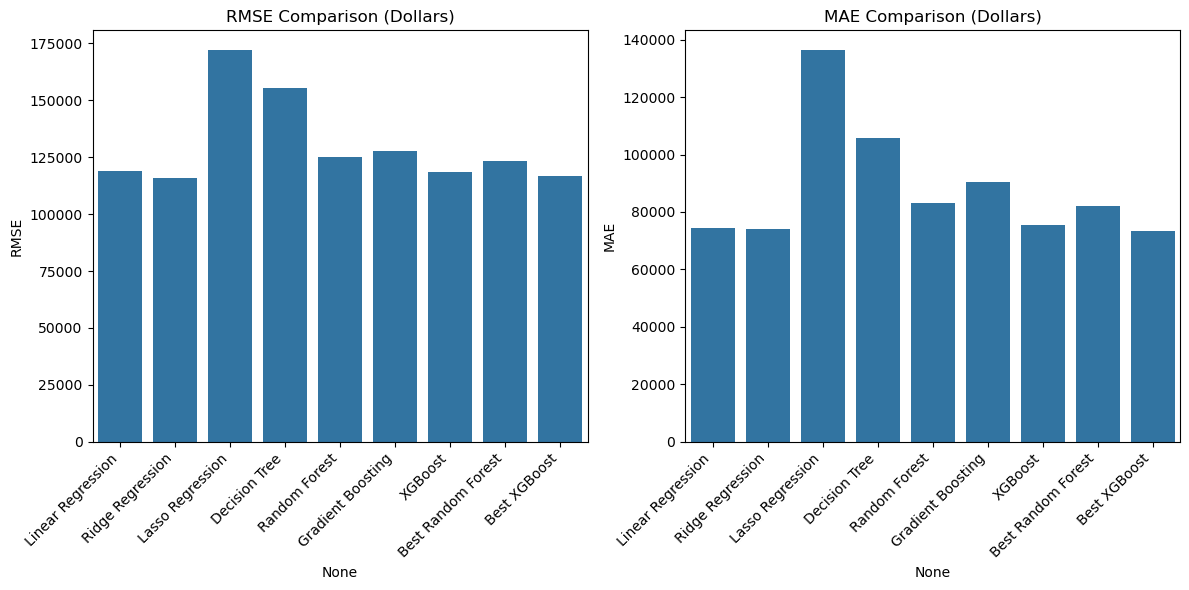

In [17]:
# Evaluate tuned Random Forest
y_pred_rf = best_rf.predict(X_test_tree)
rmse_rf = np.sqrt(mean_squared_error(y_test_tree, y_pred_rf))
mae_rf = mean_absolute_error(y_test_tree, y_pred_rf)
r2_rf = r2_score(y_test_tree, y_pred_rf)
results['Best Random Forest'] = {'RMSE': rmse_rf, 'MAE': mae_rf, 'R2': r2_rf}
print(f"Best Random Forest (Unscaled): RMSE={rmse_rf:.2f}, MAE={mae_rf:.2f}, R2={r2_rf:.4f}")

# Evaluate tuned XGBoost
y_pred_xgb = best_xgb.predict(X_test_tree)
rmse_xgb = np.sqrt(mean_squared_error(y_test_tree, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test_tree, y_pred_xgb)
r2_xgb = r2_score(y_test_tree, y_pred_xgb)
results['Best XGBoost'] = {'RMSE': rmse_xgb, 'MAE': mae_xgb, 'R2': r2_xgb}
print(f"Best XGBoost (Unscaled): RMSE={rmse_xgb:.2f}, MAE={mae_xgb:.2f}, R2={r2_xgb:.4f}")

# Display results as a DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Comparison (Unscaled Metrics):")
print(results_df.sort_values('R2', ascending=False))

# Plot RMSE and MAE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=results_df.index, y=results_df['RMSE'])
plt.xticks(rotation=45, ha='right')
plt.title('RMSE Comparison (Dollars)')
plt.subplot(1, 2, 2)
sns.barplot(x=results_df.index, y=results_df['MAE'])
plt.xticks(rotation=45, ha='right')
plt.title('MAE Comparison (Dollars)')
plt.tight_layout()
plt.show()

### 7.4. Cross-Validation

In [18]:
# Cross-validation for best Random Forest
cv_scores_rf = cross_val_score(best_rf, X_train_tree, y_train_tree, cv=5, scoring='r2')
print(f"Random Forest CV R2: Mean={cv_scores_rf.mean():.4f}, Std={cv_scores_rf.std():.4f}")

# Cross-validation for best XGBoost
cv_scores_xgb = cross_val_score(best_xgb, X_train_tree, y_train_tree, cv=5, scoring='r2')
print(f"XGBoost CV R2: Mean={cv_scores_xgb.mean():.4f}, Std={cv_scores_xgb.std():.4f}")

Random Forest CV R2: Mean=0.7292, Std=0.0124
XGBoost CV R2: Mean=0.7803, Std=0.0180


### 7.5. Feature Importance Analysis

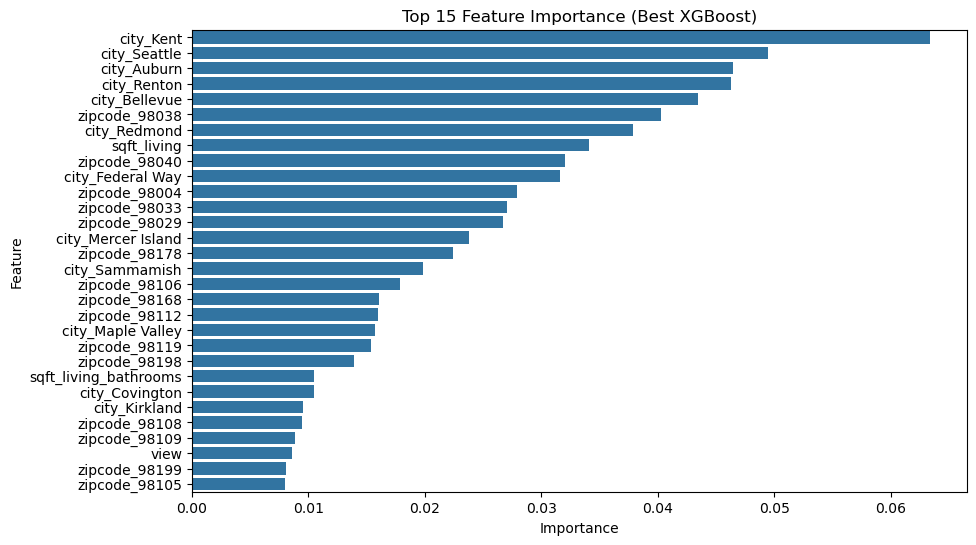

In [20]:
# Feature Importance for Best XGBoost
importances = best_xgb.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(30))
plt.title('Top 15 Feature Importance (Best XGBoost)')
plt.show()

## 8. Save the Best Model and Preprocessors

Best XGboost is selected due to it being the second best overall, but the best in regards to MAE

In [21]:
# Save the best model (XGBoost)
joblib.dump(best_xgb, '../artifacts/best_housing_model.pkl')

# Save the feature scaler
joblib.dump(scaler_X, '../artifacts/scaler_X.pkl')

# Save training columns for Dash app
joblib.dump(X.columns.tolist(), '../artifacts/training_columns.pkl')

['../artifacts/training_columns.pkl']